# Assignment


In this assignment, we will learn to use polynomial splines for estimating the relationship between features and a target. Generalized additive models are based on very similar methods, but to avoid getting into too much detail we try to expose you to some basic ideas behind GLMs.

Let's load our libraries first.

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 7]

from patsy import dmatrix, bs
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Let's turn to the `auto-price.csv` data: we will use try to use `horsepower` to predict `highway-mpg`. Here's what the scatter plot of the two looks like.

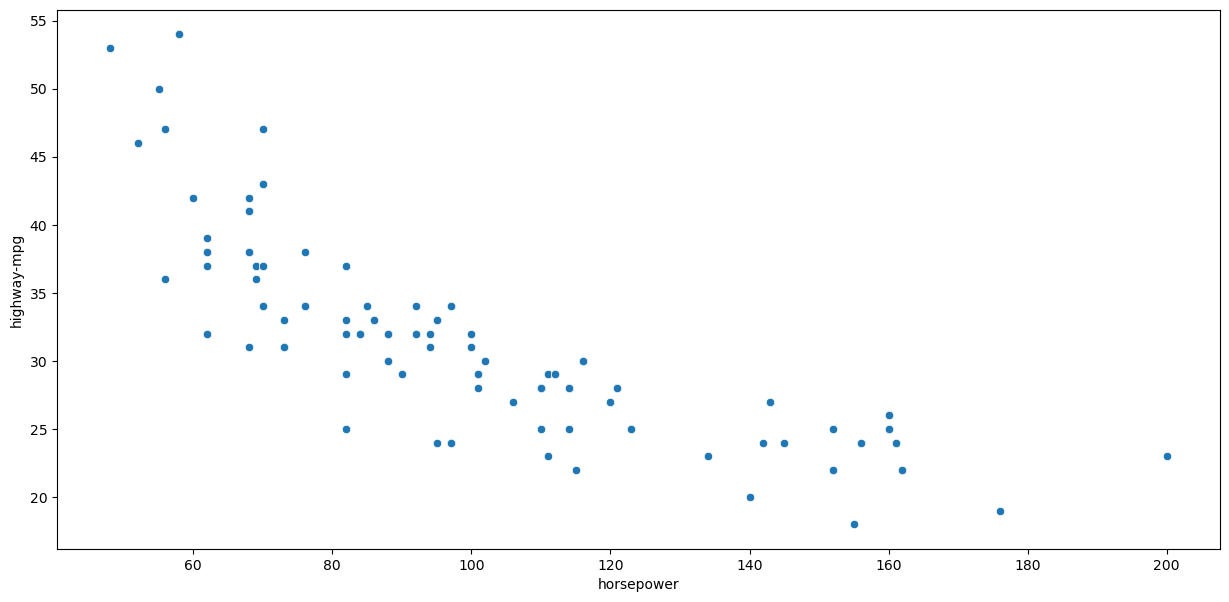

In [7]:
auto = pd.read_csv('./data/auto-price.csv', na_values = '?')
auto = auto.dropna()
sns.scatterplot(x = 'horsepower', y = 'highway-mpg', data = auto);

In [8]:
#glimpse the dataframe
auto.head() #5 rows x 26 columns
#print values and their frequency
    #to check that the values make sense
#auto["horsepower"].value_counts() #int64
#auto["highway-mpg"].value_counts() #int64

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.4,8.3,140.0,5500.0,17,20,23875.0
10,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.8,8.8,101.0,5800.0,23,29,16430.0


In [9]:
auto.shape #159 rows x 26 columns

(159, 26)

As we can see, the relationship is not linear, but curvelinear. We already know how to model this type of data: We can use polynomial regression. 

1

- Fit a polynomial regression to predict `highway-mpg` using `horsepower`. You will need to choose a degree and justify your choice. Recreate the above scatter plot and add the predicitons from the model to the plot (use `sns.lineplot`). <span style="color:red" float:right>[10 point] of 45 points </span> 

In [11]:
#error: name 'highway' is not defined <-- it did not like the hyphen due to formula
auto = auto.rename(columns = {"highway-mpg":"highway_mpg"})
auto.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway_mpg,price
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.4,8.3,140.0,5500.0,17,20,23875.0
10,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.8,8.8,101.0,5800.0,23,29,16430.0


<Axes: xlabel='horsepower', ylabel='highway_mpg'>

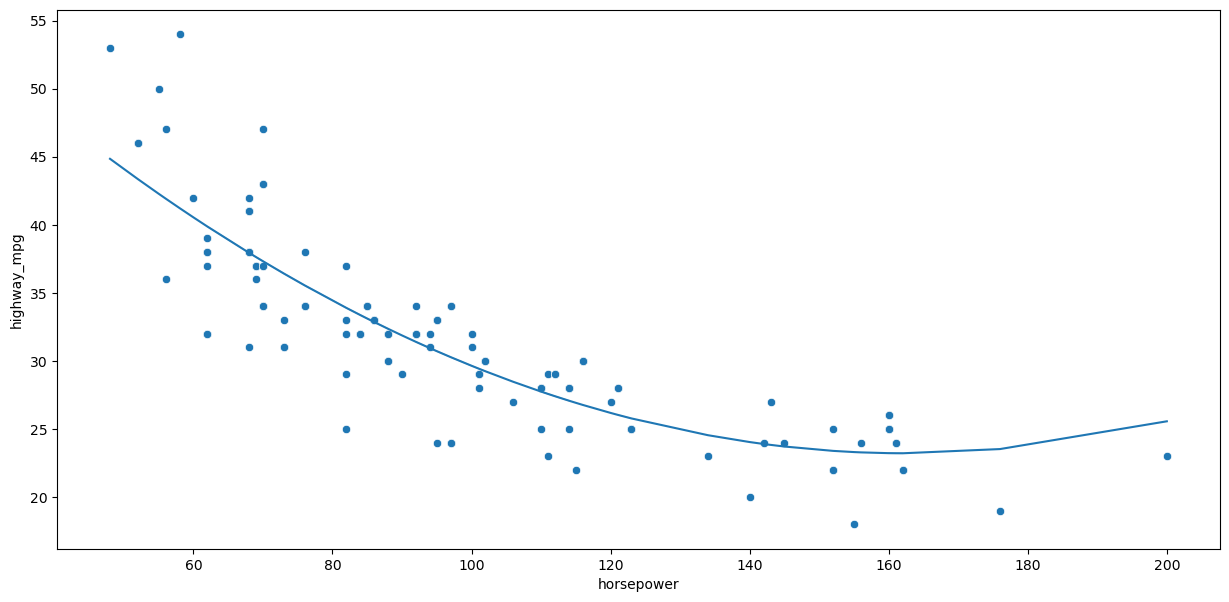

In [12]:
#STATSMODELS: linear regression / polynomial regression model --> initialized + fitted
    #Chose a polynomial of degree 2 because it resembles the curve of an even function the most
        #I would argue that it might better resemble an exponential decay function due to its rate
#polynomial_model = sm.ols("'highway-mpg' ~ poly(horsepower,2)", data = auto).fit()
polynomial_model = sm.ols(formula = "highway_mpg ~ horsepower+I(horsepower**2)", data = auto).fit()

#create an empty array to store the predictions
predictions = np.ones(shape = (len(auto), 2))
#converted the array into a dataframe
predictions = pd.DataFrame(predictions)
#gave it the x-values of horsepower
predictions.iloc[:,0] = auto.loc[:,"horsepower"] 

#predict values, rewrite to the df 
predictions.iloc[:,1] = polynomial_model.predict()

#Create scatterplot of data 
sns.scatterplot(x = 'horsepower', y = 'highway_mpg', data = auto);
#create a line of the regression predictions
sns.lineplot(data = predictions, x = predictions.iloc[:,0], y= predictions.iloc[:,1])

Splines divide the data range into smaller intervals by separations (called knots) to model non-linear relationships between variables. This basis formula ensures the polynomial is only active after the knot, creating a piecewise function. 

Let's now compare the polynomial model to the splines. To see how splines work, we will build one manually. To do so, we are going to define $B_j(X) = (X - T_j)^l$ whenever $X > T_j$ and $B_j(X) = 0$ otherwise. So first we choose some positive integer $l$, then we choose a set of $k$ points $T_1, \ldots, T_k$ we call **knots**, and for each of them, we create a feature $B_j(X)$.
- B_j(X): basis function
- j(X): j-th knot as depends on input variable
- X: input variable
- T_k: the j-th knot, for example: 3 knots: T1, T2, T3
- l: an integer that determines the degree of the polynomial

2

- Let $l = 0$ for now. Construct the features `B_1`, `B_2` and `B_3` using the knots 80, 120, 160 respectively. Then train a linear model to predict `highway-mpg` using `horsepower`, `B_1`, `B_2` and `B_3`. Print the model's coefficients, and once again plot the scatter plot of  `highway-mpg` against `horsepower` and put the prediction curve on the line. How would you describe the predictions? <span style="color:red" float:right>[10 point] of 45 pts</span>

In [14]:
#create new data frame of predictions
predictions_spline = auto[["horsepower"]].copy()

for expo in range(0,4,1): 
    l = expo # the exponent for a polynomial functions
        #0 = just a constant, #1 = linear, #2 = quadratic, #3 = cubic, ...

    T1 = 80 #knot 1
    T2 = 120 #knot 2
    T3 = 160 #knot 3

    # create __features__ (aka new columns) B1, B2, B3 as described in the basis functions shown
    auto["B1"] = ( (auto["horsepower"] - T1)**expo ).clip(lower=0) #clip sets a lower bound
    auto["B2"] = ( (auto["horsepower"] - T2)**expo ).clip(lower=0)
    auto["B3"] = ( (auto["horsepower"] - T3)**expo ).clip(lower=0)

    # train + fit a model using horsepower and the features created above
    polynomial_model = sm.ols(formula = "highway_mpg ~ horsepower + B1 + B2 + B3", data = auto).fit()

    #create a set of predictions
    predictions_spline["predictions_expo_"+str(expo)] = polynomial_model.predict()

    # print the model's coefficients
    print(polynomial_model.params)
    intercept, beta_horse, beta_1, beta_2, beta_3 = polynomial_model.params

Intercept     12.191506
horsepower    -0.174091
B1            12.191506
B2            12.191506
B3            12.191506
dtype: float64
Intercept     69.972526
horsepower    -0.470027
B1             0.337274
B2             0.032279
B3             0.063732
dtype: float64
Intercept     0.000014
horsepower    0.001691
B1            0.007231
B2           -0.014579
B3            0.009003
dtype: float64
Intercept     56.536569
horsepower    -0.272742
B1             0.000036
B2            -0.000121
B3             0.000333
dtype: float64


<Axes: xlabel='horsepower', ylabel='highway_mpg'>

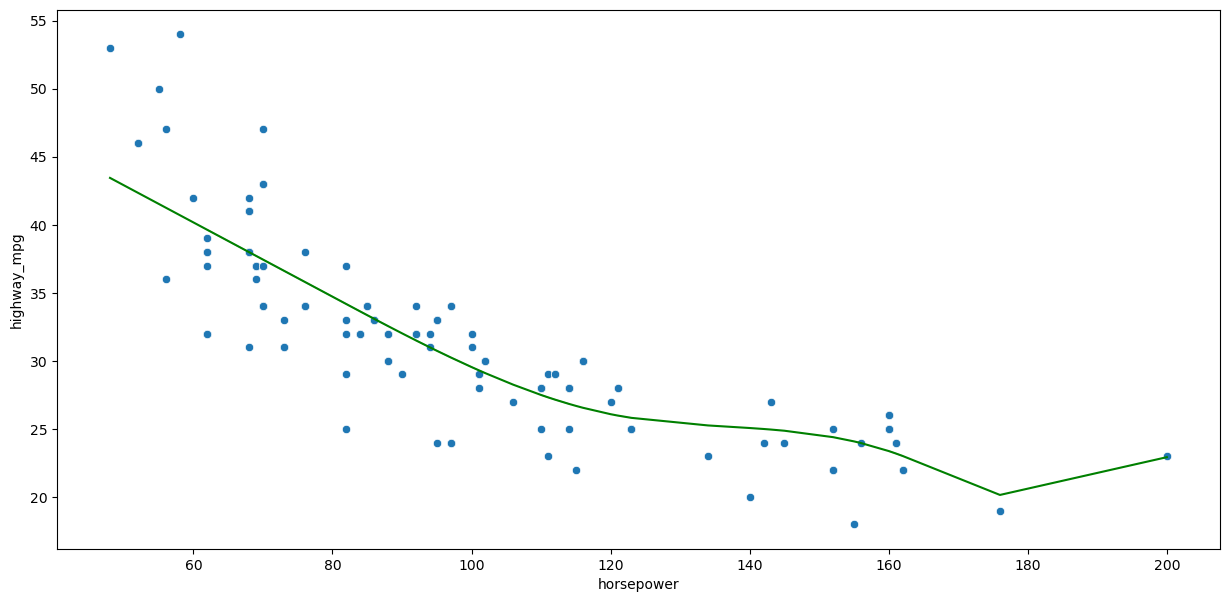

In [15]:
# plot scatter plot and prediction curve
sns.scatterplot(x = 'horsepower', y = 'highway_mpg', data = auto); #scatter of data
#sns.lineplot(data = predictions_spline, x = 'horsepower' , y= "predictions_expo_0", color="red") #line of predictions (line)
#sns.lineplot(data = predictions_spline, x = 'horsepower' , y= "predictions_expo_1", color="purple") #line of predictions (linear)
#sns.lineplot(data = predictions_spline, x = 'horsepower' , y= "predictions_expo_2", color="black") #line of predictions (quadratic)
sns.lineplot(data = predictions_spline, x = 'horsepower' , y= "predictions_expo_3", color="green") #line of predictions (cubic)

3

- Now rerun your code (in a new cell below) but this time use `l = 1` instead of `l = 0`. How would you describe the prediction curve? Repeat this with `l = 2` and `l = 3`. Which value of `l` do you think best fits the data? <span style="color:red" float:right>[10 point] of 45 pts</span>

Sorry, I reran the code above with a for-loop and stored the predictions in separate columns to compare graphs. 

<b>l = 0:</b> The prediction curve resembles a linear function. 
    It's not what I expected from the basis function having an exponent of 0, but it makes sense since horsepower is still included as a linear term. 

<b>l = 1 </b> The prediction curve resembles a piecewise function made of 4 linear pieces, divided at the knots. 

<b> l = 2 </b> The prediction curve resembles a quadratic (or even) function, assumingly piecewise. I think this one fits the best since it most closely resembles a curve similar to an exponential decay function. 

<b> l = 3 </b> The prediction curve cubic a quadratic (or odd) function, due to the mild S curve you can see when X ~ 135. 

I'm interested for why it has a linear piece around 175. I know horsepower itself lends the linear component, but there are knots around 80, 120, 160, so  why this is starting at 175, I don't know. Possibly due to only 2 points? Only way to connect 2 is by a line? 

Creating all these features manually is clearly tedious. We did it this exercise to convince you that it's not that hard, but we will now turn to a package to make things easy. In the first line of the code below, you will see the knots and the exponent `l = 2` hard-coded in a string. We pass this string to the `dmatrix` function in the next line to featurized the data accordingly. Examine the resulting data (called the **design matrix**) with all the features created. The `bs` function stands for B-splines, which are very similar to our manual splines earlier.

In [52]:
sp_type = "bs(x, knots = (80, 120, 160), degree = 3, include_intercept = False)"
X_featurized = dmatrix(sp_type, {"x": auto['horsepower']}, return_type = 'dataframe')
X_featurized.describe()
#X_featurized.head()

,Intercept,"bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[0]","bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[1]","bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[2]","bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[3]","bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[4]","bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[5]"
count,159.0,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,1.0,0.237651,0.331891,0.260504,0.095212,0.024220,0.006694
std,0.0,0.246667,0.195166,0.232865,0.179948,0.078028,0.079435
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.001042,0.190815,0.035889,0.000000,0.000000,0.000000
50%,1.0,0.158025,0.333099,0.180012,0.001333,0.000000,0.000000
75%,1.0,0.547885,0.505691,0.462379,0.102354,0.000000,0.000000
max,1.0,0.620572,0.599922,0.655015,0.596417,0.558000,1.000000


4 

As you can see below, the features created are not the same as the ones we created manually. That's because there is an additional constraint that $\sum_j B_j(X) = 1$ for all values of $X$. In other words, the $B_j$ features together add up to 1 at each row. You can read more about B-spline details [here](https://en.wikipedia.org/wiki/B-spline) if you wish, but we will not delve further into that here.

- What can you conclude judging from the percentiles in the above table. <span style="color:red" float:right>[5 point]</span>

With B0, it holds the highest coefficient, which decreases across B_j. Each subsequent B_j grows weaker with less influence. 
But, what I find interesting is the maximum value increases up to B_2, then decreases, before increasing back to 1 with B_4. Because this correlates to the degree that I find holds the most similiarites to horsepower, I wonder if this represents a best fit. 

5 

So the `dmatrix` function took care of creating all the features for us. All that's left is to train a model similar to before but using these new features now.

- Fit a linear regression model to predict `highway-mpg` using the features returned by `dmatrix`. Plot the scatter plot and prediction curve. Return to change the `degree` to 0, then 1, then 2, then 3 and notice how the prediction line changes. Describe your findings. <span style="color:red" float:right>[10 point]</span>

In [56]:
#create new data frame of predictions
predictions_linear = auto[["highway_mpg","horsepower"]].copy()
predictions_linear = pd.concat([predictions_linear,X_featurized],axis = 1)
predictions_linear = predictions_linear.rename(columns={"bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[0]": "BS0", 
                                                       "bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[1]":"BS1",
                                                       "bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[2]":"BS2",
                                                       "bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[3]":"BS3",
                                                       "bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[4]":"BS4",
                                                       "bs(x, knots=(80, 120, 160), degree=3, include_intercept=False)[5]":"BS5"})
predictions_linear.head()

,highway_mpg,horsepower,Intercept,BS0,BS1,BS2,BS3,BS4,BS5
3,30,102.0,1.0,0.028125,0.465647,0.478499,0.027729,0.00000,0.0
4,22,115.0,1.0,0.000603,0.252567,0.635176,0.111654,0.00000,0.0
6,25,110.0,1.0,0.004823,0.335269,0.589596,0.070312,0.00000,0.0
8,20,140.0,1.0,0.000000,0.022321,0.477679,0.468750,0.03125,0.0
10,29,101.0,1.0,0.033078,0.480426,0.462379,0.024117,0.00000,0.0


Intercept    51.562691
BS0         -11.710031
BS1         -19.872256
BS2         -24.644981
BS3         -29.076426
BS4         -29.788122
BS5         -28.772049
dtype: float64


<Axes: xlabel='horsepower', ylabel='highway_mpg'>

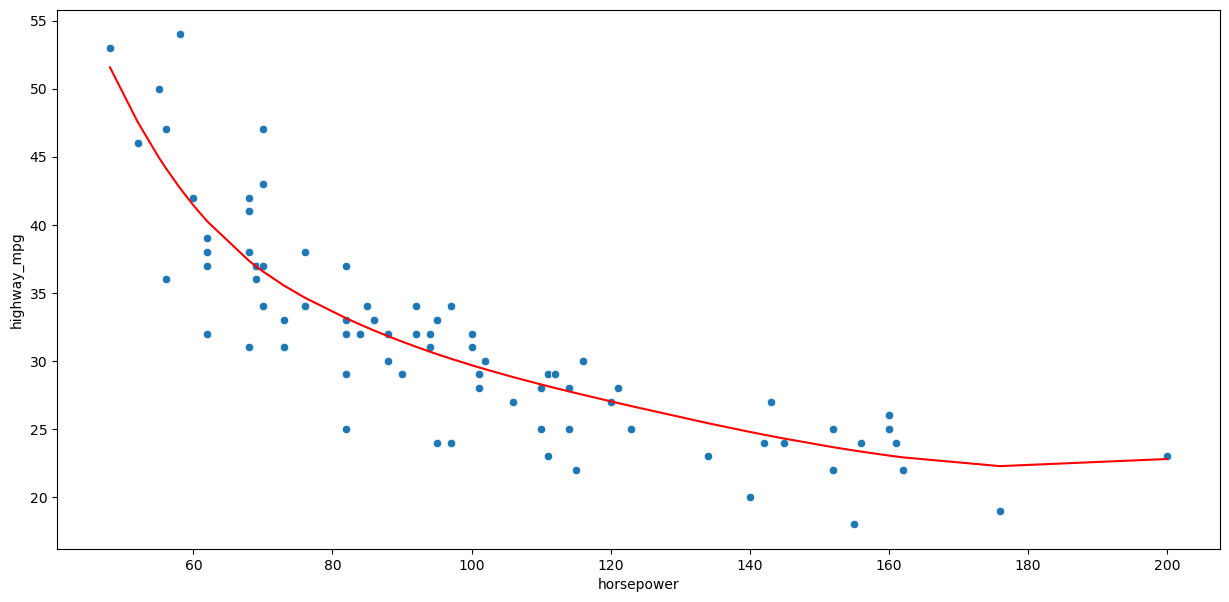

In [58]:
# train + fit a model using horsepower and the features created above
linear_model = sm.ols(formula = "highway_mpg ~ BS0 + BS1 + BS2 + BS3 + BS4 + BS5" , data = predictions_linear).fit()

#create a set of predictions
predictions_linear["predictions"] = linear_model.predict()

# print the model's coefficients
print(linear_model.params)

# plot scatter plot and prediction curve
sns.scatterplot(x = 'horsepower', y = 'highway_mpg', data = predictions_linear); #scatter of data
sns.lineplot(data = predictions_linear, x = 'horsepower' , y= "predictions", color="red") #line of predictions

1. Degree 0: Created up to BS2 ---> Create a step function (i.e. constant piecewise function)
2. Degree 1: Created up to BS3 --> Create a linear piecewise function (with breaks at the splines)
3. Degree 2: Created up to BS4 --> Create a quadratic piecewise function (with breaks at the splines)
4. Degree 3: Created up to BS5 --> Looks like another quadratic, but should be cubic, but has another linear piece at the end

With more than one feature, the basic idea is still the same, but to visualize results we can plot a separate plot for each feature $X_j$ agaist the prediction. Intuitively, we can say that every feature $X_j$ is transformed to many features (one for each basis function applied to it), and together all those transformed features are used to predict the target. Since we could end up with too many useless features at the end, we use some form of penalization like **L1-regularization** to do feature selection and avoid overfitting at the same time. So this simple yet powerful idea is what GAMs are based on.

# End of assignment